In [56]:
from numpy import asarray
from PIL import Image
from matplotlib.patches import Rectangle
from matplotlib import pyplot as plt
import cv2
from mtcnn.mtcnn import MTCNN

from os import listdir
from os.path import isdir

from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

from keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Sequential,Model
from tensorflow.python.keras.models import Input
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD

from sklearn.metrics import accuracy_score,mean_squared_error,confusion_matrix,classification_report,roc_curve



In [57]:
# 1 
# use mtcnn to detect face - get bbx, face detail 

# image_path = 'img/a.jpg'
# image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB) 
# pixels = asarray(image)
# detector = MTCNN()
# faces = detector.detect_faces(pixels)

# faces

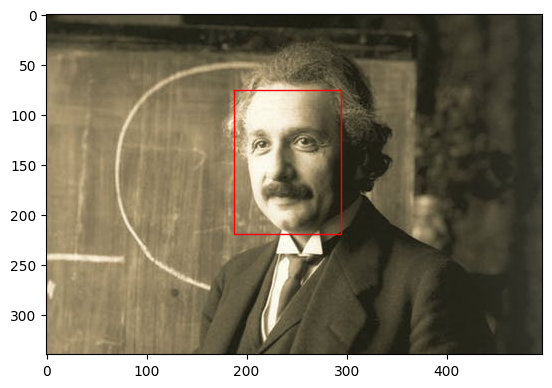

In [58]:
# 2
# highlight faces find with mtcnn 

def highlight_faces(image_path, faces):
  # display image
    image = plt.imread(image_path)
    plt.imshow(image)
    
    #save plt ke bala anjam dad
    ax = plt.gca()

   #draw a rectangle for faces 
    for face in faces:
        x, y, width, height = face['box']
        face_border = Rectangle((x, y), width, height,
                          fill=False, color='red')
        ax.add_patch(face_border)
    plt.show()

highlight_faces(image_path, faces)

2/2 [==============================] - 0s 6ms/step


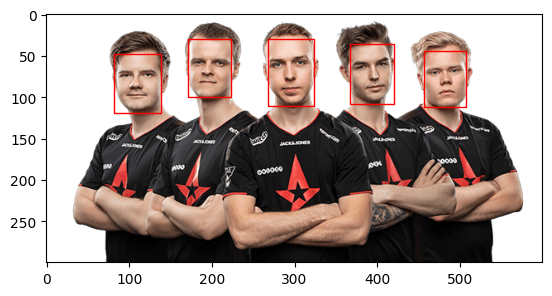

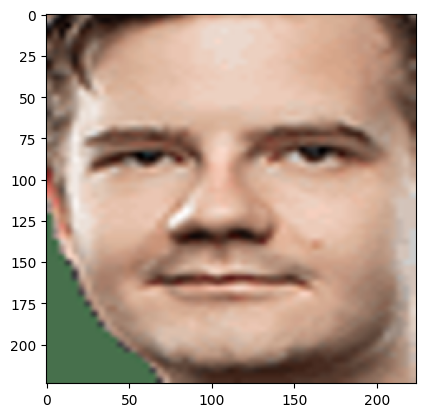

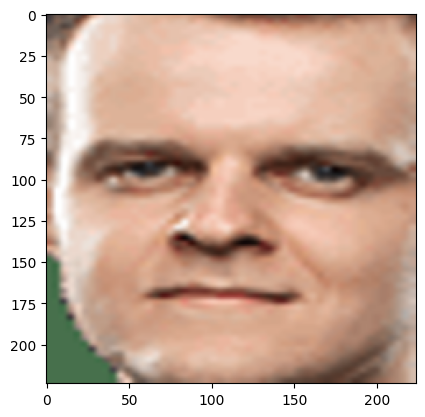

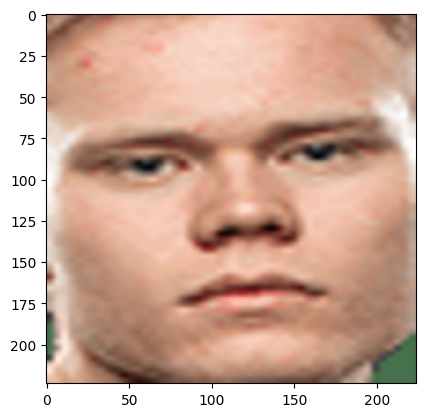

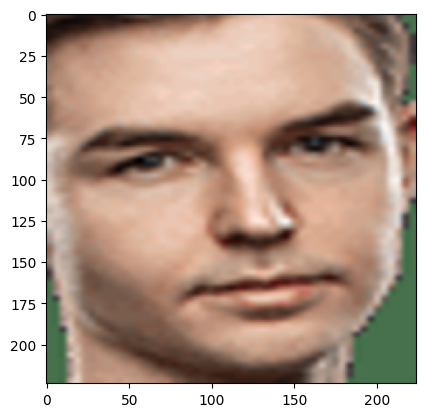

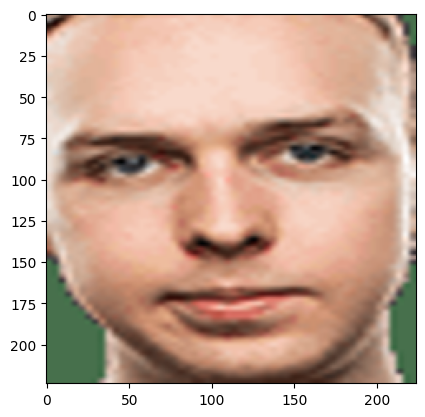

In [59]:
# 3
#cropped faces find with mtcnn to train to network

def extract_face_from_image(image_path, required_size=(224, 224)):
  # load image and detect faces
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    pixels = asarray(image)
    detector = MTCNN()
    faces = detector.detect_faces(pixels)
    faces
    highlight_faces(image_path, faces)

    face_images = []

    for face in faces:
        # extract the bounding box from the requested face
        x1, y1, width, height = face['box']
        x1, y1 = abs(x1), abs(y1)

        x2, y2 = x1 + width, y1 + height
        # extract the face
        face_boundary = pixels[y1:y2, x1:x2]

        # resize pixels to the model size
        face_image = Image.fromarray(face_boundary)
        face_image = face_image.resize(required_size)
        face_array = asarray(face_image)
        face_images.append(face_array)

    return face_images

extracted_face = extract_face_from_image('img/x.png')
# Display the first face from the extracted faces
for i in range(0,len(extracted_face)):
    plt.imshow(extracted_face[i])
    plt.show()

In [61]:
# 4
# from dataset load train and validation img - preprocess


# -----------------------------------------------------------
def extract_face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    
    # convert to RGB, if needed
    image = image.convert('RGB')
    
    # convert to array
    pixels = asarray(image)
    
    # create the detector, using default weights
    detector = MTCNN()
    
    # detect faces in the image
    results = detector.detect_faces(pixels)
    
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    
    # bug fix
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    
    # extract the face
    face = pixels[y1:y2, x1:x2]
    
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = asarray(image)
    
    return face_array
# -----------------------------------------------------------
def load_faces(directory):
    faces = list()
    
    # enumerate files
    for filename in listdir(directory):
        # path
        path = directory + filename
        
        # extract face
        face = extract_face(path)
        
        # store
        faces.append(face)
        
    return faces

# -----------------------------------------------------------
def load_dataset(directory):
    #X, y = train-data , label
    X, y = list(), list()
    
    # enumerate folders, on per class
    for subdir in listdir(directory):
        # path
        path = directory + subdir + '/'
        
        # skip any files that might be in the dir
        if not isdir(path):
            continue
        
        # load all faces in the subdirectory
        faces = load_faces(path)
        
        # create labels
        labels = [subdir for _ in range(len(faces))]
        
        # summarize progress
        print('>loaded %d examples for class: %s' % (len(faces), subdir))
        
        # store
        X.extend(faces)
        y.extend(labels)
        
    return asarray(X), asarray(y)
# -----------------------------------------------------------

# load train dataset
# trainX, trainy = train-img , label
trainX, trainy = load_dataset('dataset/train/')
print(trainX.shape, trainy.shape)

# load test dataset
# testX, testy = val-img , label
testX, testy = load_dataset('dataset/val/')

# save arrays to one file in compressed format
# savez_compressed('5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

1/1 [==============================] - 0s 109ms/step
>loaded 14 examples for class: ben_afflek
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 105ms/step
>loaded 17 examples for class: elton_john
1/1 [==============================] - 0s 87ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 112ms/step
>loaded 21 examples for class: jerry_seinfeld
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 100ms/step
>loaded 19 examples for class: madonna
1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 120ms/step
>loaded 22 examples for class: mindy_kaling
(93, 160, 160, 3) (93,)
1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 105ms/step
>loaded 5 examples for class: ben_afflek
1/1 [==============================] - 0s 163ms/step
>loaded 5 examples for class: elton_john
1/1 [==============================] - 0s 117ms/step
>loaded 5 examples for class: jerry_seinfeld
1/1 [==============================] - 0s 129ms/step
>loaded 5 examples for class: madonna
1/1 [==============================] - 0s 83ms/step


1/1 [==============================] - 0s 101ms/step
>loaded 5 examples for class: mindy_kaling


In [62]:
# 5
# string label comnvert to int 

from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

label_encoder= LabelEncoder()
trainy = label_encoder.fit_transform(trainy) #string labels to int lables
trainy = to_categorical(trainy,5) #int labels to catgorical labels

testy = label_encoder.fit_transform(testy) #string labels to int lables
testy = to_categorical(testy,5) #int labels to catgorical labels

In [91]:
# 6
# train network  

from keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Sequential,Model
from tensorflow.python.keras.models import Input
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD

# data masnoyi ijad konim ke ba nerkh moshkhas taghirat ejra
imgsize = 160
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False) 

augs_gen.fit(trainX)

In [92]:
# 7
# use vgg

base_model = VGG16(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')

# layer hay aval vgg bedon taghir mizarim = yadgiri behtar - jobran kambod dade 
for layer in base_model.layers:
    layer.trainable = False 
    
for layer in base_model.layers:
    print(layer,layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x00000166E34607F0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000166E34609D0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000166E344FD90> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x00000166BAEE5BA0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000166B9CA6E90> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000166E34C1D80> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x00000166E34C2E00> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000166E34C2830> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000166E34C3DC0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000166E3833E20> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x00000166E34C8610> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x00000166E34C8CD0> False
<keras.layers.convolutional.conv2d.Conv2D object

In [93]:
# 8
# create custome layer

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))
model.add(Dense(5,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d_3   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_941 (Dense)           (None, 5)                 2565      
                                                                 
Total params: 14,717,253
Trainable params: 2,565
Non-trainable params: 14,714,688
_________________________________________________________________


In [94]:
# 9
# tabe khata : crossentropy

opt = SGD(learning_rate=1e-4,momentum=0.99)
opt1 = Adam(learning_rate=1e-3)

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt1,
    metrics=['accuracy']
)

Epoch 1/300
25/25 [==============================] - 4s 161ms/step - loss: 4.7002 - accuracy: 0.4000 - val_loss: 3.5212 - val_accuracy: 0.4000
Epoch 2/300
25/25 [==============================] - 4s 159ms/step - loss: 4.9926 - accuracy: 0.4000 - val_loss: 3.3479 - val_accuracy: 0.4400
Epoch 3/300
25/25 [==============================] - 4s 162ms/step - loss: 1.2407 - accuracy: 0.7200 - val_loss: 3.1122 - val_accuracy: 0.4800
Epoch 4/300
25/25 [==============================] - 4s 163ms/step - loss: 4.0227 - accuracy: 0.6000 - val_loss: 3.4003 - val_accuracy: 0.4400
Epoch 5/300
25/25 [==============================] - 4s 172ms/step - loss: 5.5937 - accuracy: 0.3600 - val_loss: 1.9957 - val_accuracy: 0.4800
Epoch 6/300
25/25 [==============================] - 4s 162ms/step - loss: 1.7425 - accuracy: 0.6400 - val_loss: 2.0508 - val_accuracy: 0.6400
Epoch 7/300
25/25 [==============================] - 4s 176ms/step - loss: 4.0448 - accuracy: 0.5600 - val_loss: 2.0516 - val_accuracy: 0.5600

Epoch 58/300
25/25 [==============================] - 5s 219ms/step - loss: 1.2681 - accuracy: 0.8000 - val_loss: 0.5704 - val_accuracy: 0.8000
Epoch 59/300
25/25 [==============================] - 5s 214ms/step - loss: 0.4067 - accuracy: 0.8400 - val_loss: 0.1122 - val_accuracy: 0.9600
Epoch 60/300
25/25 [==============================] - 5s 206ms/step - loss: 0.9976 - accuracy: 0.7200 - val_loss: 0.5985 - val_accuracy: 0.8000
Epoch 61/300
25/25 [==============================] - 5s 206ms/step - loss: 0.9010 - accuracy: 0.8400 - val_loss: 0.4225 - val_accuracy: 0.8800
Epoch 62/300
25/25 [==============================] - 5s 204ms/step - loss: 1.0541 - accuracy: 0.8400 - val_loss: 0.5003 - val_accuracy: 0.8400
Epoch 63/300
25/25 [==============================] - 5s 200ms/step - loss: 0.4480 - accuracy: 0.8400 - val_loss: 0.0916 - val_accuracy: 0.9600
Epoch 64/300
25/25 [==============================] - 5s 196ms/step - loss: 0.3472 - accuracy: 0.8000 - val_loss: 0.2824 - val_accuracy:

Epoch 115/300
25/25 [==============================] - 6s 226ms/step - loss: 0.5351 - accuracy: 0.8800 - val_loss: 0.2807 - val_accuracy: 0.8400
Epoch 116/300
25/25 [==============================] - 5s 213ms/step - loss: 0.3251 - accuracy: 0.9200 - val_loss: 0.3417 - val_accuracy: 0.9200
Epoch 117/300
25/25 [==============================] - 5s 216ms/step - loss: 0.1179 - accuracy: 0.9200 - val_loss: 0.1353 - val_accuracy: 0.9200
Epoch 118/300
25/25 [==============================] - 5s 207ms/step - loss: 0.6358 - accuracy: 0.8400 - val_loss: 0.0263 - val_accuracy: 1.0000
Epoch 119/300
25/25 [==============================] - 5s 199ms/step - loss: 0.3475 - accuracy: 0.8400 - val_loss: 0.0687 - val_accuracy: 1.0000
Epoch 120/300
25/25 [==============================] - 5s 200ms/step - loss: 0.4804 - accuracy: 0.8800 - val_loss: 0.0355 - val_accuracy: 1.0000
Epoch 121/300
25/25 [==============================] - 5s 205ms/step - loss: 0.1297 - accuracy: 0.9200 - val_loss: 0.1467 - val_ac

25/25 [==============================] - 6s 238ms/step - loss: 0.0162 - accuracy: 1.0000 - val_loss: 0.1721 - val_accuracy: 0.9200
Epoch 172/300
25/25 [==============================] - 6s 243ms/step - loss: 0.3031 - accuracy: 0.9200 - val_loss: 0.0223 - val_accuracy: 1.0000
Epoch 173/300
25/25 [==============================] - 6s 225ms/step - loss: 0.5489 - accuracy: 0.8800 - val_loss: 0.0565 - val_accuracy: 1.0000
Epoch 174/300
25/25 [==============================] - 6s 236ms/step - loss: 0.0628 - accuracy: 1.0000 - val_loss: 0.1837 - val_accuracy: 0.9200
Epoch 175/300
25/25 [==============================] - 6s 239ms/step - loss: 0.6081 - accuracy: 0.8800 - val_loss: 0.0460 - val_accuracy: 0.9600
Epoch 176/300
25/25 [==============================] - 6s 235ms/step - loss: 0.1688 - accuracy: 0.9200 - val_loss: 0.2274 - val_accuracy: 0.9600
Epoch 177/300
25/25 [==============================] - 6s 237ms/step - loss: 0.4479 - accuracy: 0.9600 - val_loss: 0.1358 - val_accuracy: 0.9200

25/25 [==============================] - 5s 210ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.3849 - val_accuracy: 0.9200
Epoch 228/300
25/25 [==============================] - 5s 206ms/step - loss: 0.3090 - accuracy: 0.8800 - val_loss: 0.2497 - val_accuracy: 0.9200
Epoch 229/300
25/25 [==============================] - 5s 212ms/step - loss: 0.3274 - accuracy: 0.9200 - val_loss: 0.1688 - val_accuracy: 0.9200
Epoch 230/300
25/25 [==============================] - 5s 211ms/step - loss: 0.0926 - accuracy: 0.9600 - val_loss: 0.2355 - val_accuracy: 0.9200
Epoch 231/300
25/25 [==============================] - 5s 219ms/step - loss: 0.4397 - accuracy: 0.9200 - val_loss: 0.3101 - val_accuracy: 0.9200
Epoch 232/300
25/25 [==============================] - 5s 219ms/step - loss: 1.1103 - accuracy: 0.8400 - val_loss: 0.3965 - val_accuracy: 0.8800
Epoch 233/300
25/25 [==============================] - 5s 219ms/step - loss: 0.3083 - accuracy: 0.9200 - val_loss: 0.2875 - val_accuracy: 0.9200

25/25 [==============================] - 5s 223ms/step - loss: 0.2043 - accuracy: 0.9600 - val_loss: 0.0370 - val_accuracy: 1.0000
Epoch 284/300
25/25 [==============================] - 6s 230ms/step - loss: 0.1790 - accuracy: 0.9600 - val_loss: 0.0121 - val_accuracy: 1.0000
Epoch 285/300
25/25 [==============================] - 5s 223ms/step - loss: 0.3853 - accuracy: 0.8800 - val_loss: 0.1307 - val_accuracy: 0.9600
Epoch 286/300
25/25 [==============================] - 6s 224ms/step - loss: 0.0318 - accuracy: 0.9600 - val_loss: 0.1137 - val_accuracy: 0.9600
Epoch 287/300
25/25 [==============================] - 6s 228ms/step - loss: 0.3482 - accuracy: 0.9600 - val_loss: 0.1282 - val_accuracy: 0.9600
Epoch 288/300
25/25 [==============================] - 6s 236ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.1960 - val_accuracy: 0.9200
Epoch 289/300
25/25 [==============================] - 6s 231ms/step - loss: 0.2558 - accuracy: 0.9600 - val_loss: 0.1051 - val_accuracy: 0.9600

Text(0.5, 1.0, 'Accuracy Curves')

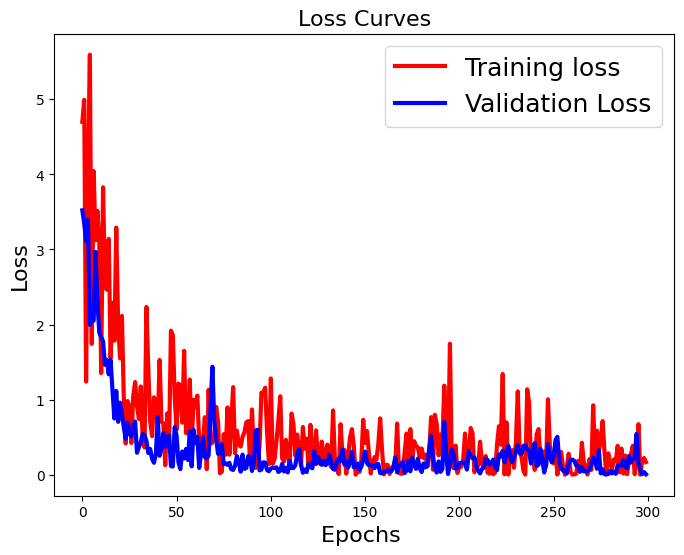

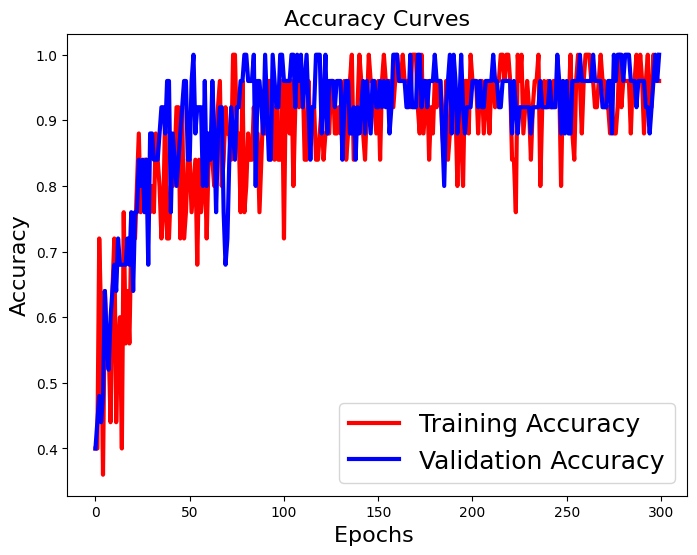

In [96]:
# 10
# data be shabake yad bedim 
from tensorflow.python.keras.models import Sequential,Model

TrainedModel = model.fit(
    augs_gen.flow(trainX,trainy,batch_size=1),
    validation_data  = (testX,testy),
    validation_steps = len(testX),
    steps_per_epoch  = len(testX),
    epochs = 300)

#Check the loss and accuracy curves:
plt.figure(figsize=[8,6])
plt.plot(TrainedModel.history['loss'],'r',linewidth=3.0)
plt.plot(TrainedModel.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

plt.figure(figsize=[8,6])
plt.plot(TrainedModel.history['accuracy'],'r',linewidth=3.0)
plt.plot(TrainedModel.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [98]:
# model.save('detector.h5')
# from keras.models import load_model
# detector = load_model('detector.h5')

In [100]:
# 11
# predict
from sklearn.metrics import accuracy_score,mean_squared_error,confusion_matrix,classification_report,roc_curve
import numpy as np

y_predict= model.predict(testX)
MAE=mean_squared_error(testy,y_predict)
print('MAE  ={} '.format(MAE))


from sklearn.metrics import classification_report
print(classification_report( np.argmax(testy, axis=1), np.argmax(y_predict, axis=1)))

1/1 [==============================] - 1s 1s/step
MAE  =0.00016356396372430027 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



1/1 [==============================] - 0s 137ms/step


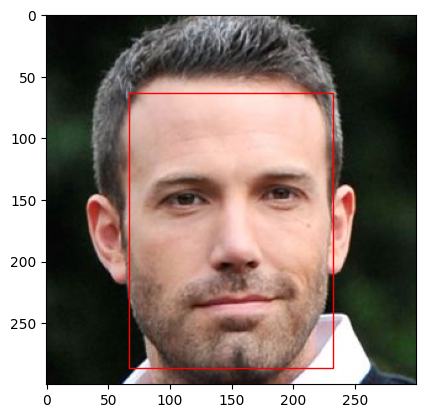

***********************
1/1 [==============================] - 0s 107ms/step
[[0.29321295 0.12807025 0.17096536 0.14615034 0.26160112]]
Predict class is: 0
ben_afflek


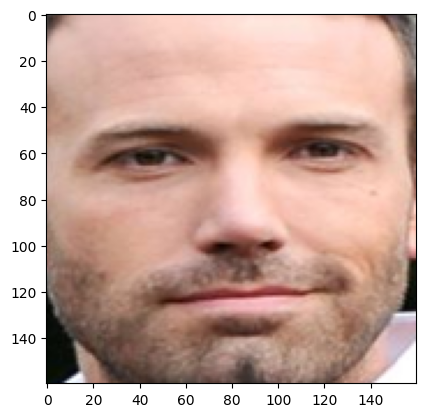

In [120]:
# 12
# recognize 

# ----------------------------------------------------------------
def highlight_faces(image_path, faces):
  # display image
    image = plt.imread(image_path)
    plt.imshow(image)

    ax = plt.gca()

    # for each face, draw a rectangle based on coordinates
    for face in faces:
        x, y, width, height = face['box']
        face_border = Rectangle((x, y), width, height,
                          fill=False, color='red')
        ax.add_patch(face_border)
    plt.show()
# ----------------------------------------------------------------
def extract_face(image_path, required_size=(160, 160)):
  # load image and detect faces
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    pixels = asarray(image)
    detector = MTCNN()
    faces = detector.detect_faces(pixels)
    faces
    highlight_faces(image_path, faces)

    face_images = []

    for face in faces:
        # extract the bounding box from the requested face
        x1, y1, width, height = face['box']
        x1, y1 = abs(x1), abs(y1)

        x2, y2 = x1 + width, y1 + height
        # extract the face
        face_boundary = pixels[y1:y2, x1:x2]

        # resize pixels to the model size
        face_image = Image.fromarray(face_boundary)
        face_image = face_image.resize(required_size)
        face_array = asarray(face_image)
        face_images.append(face_array)

    return face_images
# ----------------------------------------------------------------
def predict_class_face(ex_face):
    extracted_face = np.array(ex_face)
    extracted_face=extracted_face/255
    extracted_face = np.expand_dims(extracted_face,axis=0)
    result = model.predict(extracted_face)
    print(result)
    print('Predict class is:',np.argmax(result))

    if np.argmax(result)==0:
        print('ben_afflek')
    elif np.argmax(result)==1:
        print('elton_john')
    elif np.argmax(result)==2:
        print('jerry_seinfeld')
    elif np.argmax(result)==3:
        print('madonna')
    elif np.argmax(result)==4:
        print('mindy_kaling')
# ----------------------------------------------------------------

ext_face = extract_face('img/8.jpg')
for face in ext_face:
    print('***********************')
    predict_class_face(face)  
    plt.imshow(face)
    plt.show()